In [7]:
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
from pathlib import Path

In [22]:
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import re

### API

In [5]:
from utils.bbox.conversation import bbox_voc2yolo
from utils.plots.plots import draw_bbox
from utils.data.transfer import copy_data_mkdir, write_txt, run_task_multithread

### 数据集信息

In [14]:
!ls /nas/chenyi/datasets_cls/watoo400k/hwpedia_all/

crops  hwpedia	labels


In [120]:
watoo470k_df = pd.read_csv('./data/watoo470k.csv')
watoo470k_org_df = pd.read_csv('./data/watoo470k_origin.csv')
# watoo470k_df.to_csv('./data/watoo470k.csv', index=False)
len(watoo470k_df), len(watoo470k_org_df)

/tmp/ipykernel_2127353/4075486656.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  watoo470k_df = pd.read_csv('./data/watoo470k.csv')


(478504, 478509)

In [71]:
watoo470k_df['stem'] =  watoo470k_df['path'].apply(lambda x: Path(x).stem)
watoo470k_org_df['stem'] = watoo470k_org_df['path'].apply(lambda x: Path(x).stem)

In [124]:
watoo470k_df.head(2).values

array([['/nas/chenyi/datasets_cls/watoo400k/hwpedia_all/hwpedia/0000b94a-0b0b-4817-81d8-7c28d5284921.jpg',
        '0000b94a-0b0b-4817-81d8-7c28d5284921',
        '/nas/lichangjian/wardrobe_2/done_/正装女鞋_setdiff/0000b94a-0b0b-4817-81d8-7c28d5284921.jpg',
        '正装女鞋_setdiff'],
       ['/nas/chenyi/datasets_cls/watoo400k/hwpedia_all/hwpedia/00020a8c-9452-48c5-b01f-0ec7bd40b919.jpg',
        '00020a8c-9452-48c5-b01f-0ec7bd40b919',
        '/nas/lichangjian/wardrobe_2/done_/包包_setdiff/00020a8c-9452-48c5-b01f-0ec7bd40b919.jpg',
        '包包_setdiff']], dtype=object)

In [108]:
watoo470k_org_df.head(2)

,path,stem
0,/nas/lichangjian/wardrobe_2/done_/T恤/201808220...,2018082201120949598
1,/nas/lichangjian/wardrobe_2/done_/T恤/201708301...,2017083017334726315


In [93]:
df_dup = watoo470k_org_df.drop_duplicates('stem')

In [101]:
org_df = df_dup[df_dup['stem'].isin(watoo470k_df['stem'])]

In [104]:
watoo470k_df.sort_values('stem', inplace=True)
org_df.sort_values('stem', inplace=True)

/tmp/ipykernel_2127353/3124216541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  org_df.sort_values('stem', inplace=True)


In [113]:
watoo470k_df['img_sp'] = org_df['path'].values

In [116]:
watoo470k_df['folder'] = watoo470k_df['img_sp'].apply(lambda x: re.findall('done_/(.*?)/', x)[0])

In [131]:
folder_df = watoo470k_df['folder'].drop_duplicates().values.tolist()

In [133]:
root = '/nas/lichangjian/wardrobe_2/done_/'

In [182]:
troot = '/nas/chenyi/datasets_cls/watoo400k/hwpedia_all/hwpedia_folder/'

In [135]:
folder_list = []
for ind, v in tqdm(enumerate(folder_df)):
    f_dir = f'{root}{v}/*'
    l = len(glob.glob(f_dir))
    folder_list.append(l)
    # break

37it [00:05,  6.37it/s]


In [137]:
name2num = {}
for k,v in zip(folder_df, folder_list):
    name2num[k] = v

In [141]:
import json
with open('./data/watoo_name2num.json', 'w') as f:
    json.dump(name2num, f)

In [179]:
def copy_data_mkdir(plist, mode='move'):
    ps = Path(plist[0])
    pt = Path(plist[1])
    if not pt.parent.is_dir():
        pt.parent.mkdir(parents=True, exist_ok=True)
    if not pt.is_file():
        if mode=='move':
            Path.rename(ps, pt)
        else:
            shutil.copyfile(ps, pt)

In [183]:
import random
tp_list = []
for ind, row in tqdm(watoo470k_df.iterrows()):
    stem = row['stem']
    folder = row['folder']
    folder_num = name2num[folder]
    folder_name = str(random.randint(0,folder_num//100))
    tp = f'{troot}{folder}/{folder_name}/{stem}.jpg'
    tp_list.append(tp)

478504it [00:12, 39521.42it/s]


In [184]:
watoo470k_df['img_tp'] = tp_list

In [185]:
input_list = [list(item) for item in zip(watoo470k_df['path'], watoo470k_df['img_tp'])]

In [186]:
input_list[0]

['/nas/chenyi/datasets_cls/watoo400k/hwpedia_all/hwpedia/0000b94a-0b0b-4817-81d8-7c28d5284921.jpg',
 '/nas/chenyi/datasets_cls/watoo400k/hwpedia_all/hwpedia_folder/正装女鞋_setdiff/164/0000b94a-0b0b-4817-81d8-7c28d5284921.jpg']

In [187]:
%%time
run_task_multithread(input_list, copy_data_mkdir, thread_num=20)

CPU times: user 40.5 s, sys: 33.1 s, total: 1min 13s
Wall time: 17min 49s


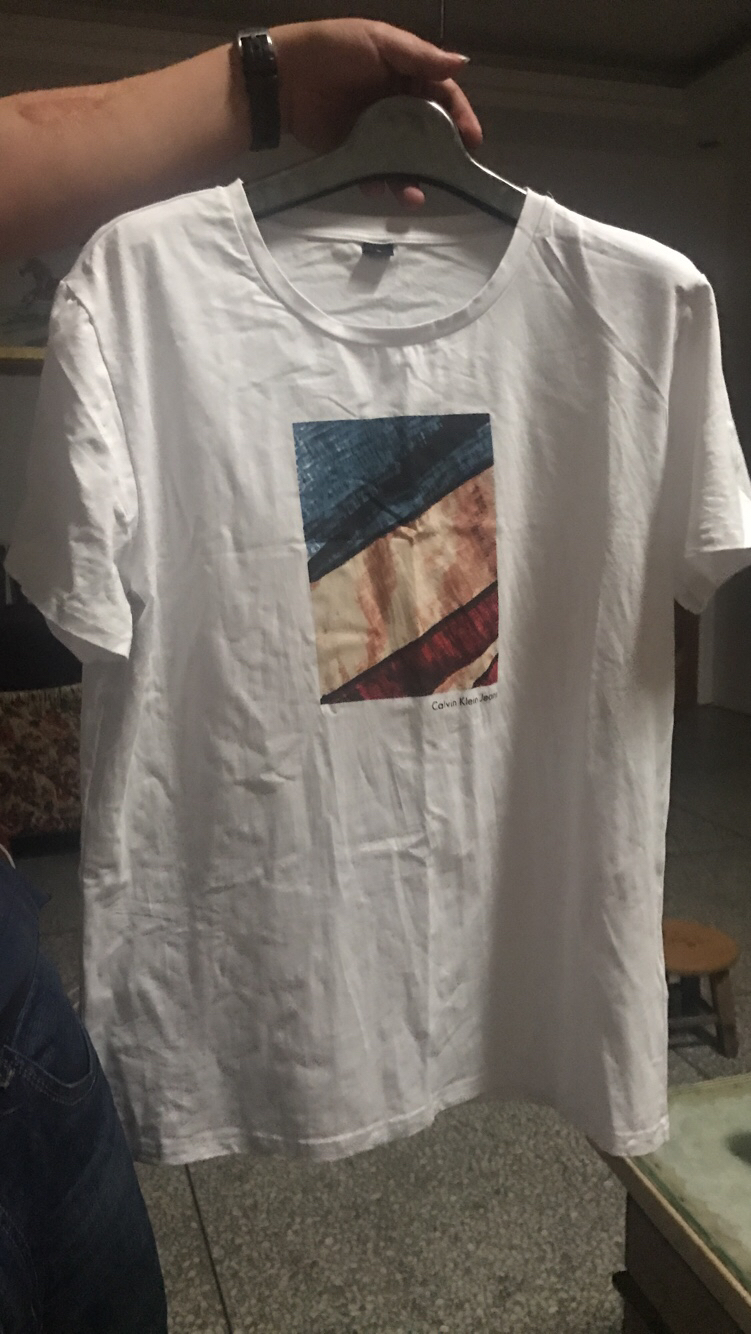

In [34]:
Image.open(watoo470k_org_df.iloc[0,0])

### 多线程数据处理

In [ ]:
%%time
df = dpedia_catg23
input_list = df.apply(lambda x: 
                        [x['label_tpath'], 
                         '{0:.0f} {1:.6f} {2:.6f} {3:.6f} {4:.6f}\n'.format(
                             *x.loc[['label_2', 'x_1','y_1', 'x_2', 'y_2',]])], 
                        axis=1)

In [ ]:
%%time
run_task_multithread(input_list, write_txt, thread_num=20)

### Deepfashion2_catg23 copy

In [ ]:
from PIL import Image
Image.open('/nas/lichangjian/open_fashion/DeepFashion2/validation/image/032151.jpg')

In [208]:
deep2_ps['img_tp'] = deep2_ps['img_sp'].apply(lambda x:x.replace('/nas/lichangjian/open_fashion/DeepFashion2/', '/home/chenyi/workspace/dataset/deepfashion2_catg24/'))

In [214]:
df = deep2_ps
input_list = df.apply(lambda x: 
                        [x['img_sp'], 
                        x['img_tp']], 
                        axis=1)

In [221]:
%%time
from data.transferData import run_task_multithread
run_task_multithread(input_list, copy_data, thread_num=10)

CPU times: user 1min 36s, sys: 1min 51s, total: 3min 28s
Wall time: 41min 56s


In [ ]:
import os

In [ ]:
dpedia_catg23.head()

In [ ]:
dpedia_catg23_img = dpedia_catg23.drop_duplicates('label_tpath')

In [ ]:
dpedia_catg23_img.info()

In [ ]:
dpedia_catg23_slink = pd.DataFrame()

In [ ]:
dpedia_catg23_slink['img_sp'] = dpedia_catg23_img['path']

In [ ]:
dpedia_catg23_slink['mode'] = dpedia_catg23_img['mode']

In [ ]:
dpedia_catg23_slink['label_sp'] = dpedia_catg23_img['label_tpath']

In [ ]:
dpedia_catg23_slink.head()

In [ ]:
save_dir = Path('/home/chenyi/workspace/yolov5/datasets/deepedia_catg24/labels/')

In [ ]:
dpedia_catg23_slink['img_tp'] = dpedia_catg23_slink['img_tp'].apply(lambda x: str(x).replace('.txt',
                                                                                            '.jpg'))

In [ ]:
%%time
_ = dpedia_catg23_slink.apply(lambda row: os.symlink(row['label_sp'], row['label_tp']), axis=1)

In [ ]:
%%time
_ = dpedia_catg23_slink.apply(lambda row: os.symlink(row['img_sp'], row['img_tp']), axis=1)

In [ ]:
# !mkdir /home/chenyi/workspace/yolov5/datasets/deepedia_catg24/images/train

In [ ]:
!tree -d -L 2 /home/chenyi/workspace/yolov5/datasets/deepedia_catg24

In [ ]:
len(glob.glob('/home/chenyi/workspace/yolov5/datasets/deepedia_catg24/images/*/*.jpg'))